# Using EMI-FastGRNN on the HAR Dataset

This is a very simple example of how the existing EMI-FastGRNN implementation can be used on the HAR dataset. We illustrate how to train a model that predicts on 48 step sequence in place of the 128 length baselines while attempting to predict early. For more advanced use cases which involves more sophisticated computation graphs or loss functions, please refer to the doc strings provided with the released code.

In the preprint of our work, we use the terms *bag* and *instance* to refer to the RNN input sequence of original length and the shorter ones we want to learn to predict on, respectively. In the code though, *bag* is replaced with *instance* and *instance* is replaced with *sub-instance*. We will use the term *instance* and *sub-instance* interchangeably.

The network used here is a simple RNN + Linear classifier network. 

The UCI [Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) dataset.

In [9]:
from __future__ import print_function
import os
import sys
import tensorflow as tf
import numpy as np
sys.path.insert(0, '../../')
os.environ['CUDA_VISIBLE_DEVICES'] ='-1'

# FastGRNN and FastRNN imports
from edgeml.graph.rnn import EMI_DataPipeline
from edgeml.graph.rnn import EMI_FastGRNN
from edgeml.graph.rnn import EMI_FastRNN
from edgeml.trainer.emirnnTrainer import EMI_Trainer, EMI_Driver
import edgeml.utils

Let us set up some network parameters for the computation graph.

In [10]:
# Network parameters for our FastGRNN + FC Layer
NUM_HIDDEN = 128
NUM_TIMESTEPS = 48
NUM_FEATS = 9
FORGET_BIAS = 1.0
NUM_OUTPUT = 3
USE_DROPOUT = False
KEEP_PROB = 0.9

# Non-linearities can be chosen among "tanh, sigmoid, relu, quantTanh, quantSigm"
UPDATE_NL = "quantTanh"
GATE_NL = "quantSigm"

# Ranks of Parameter matrices for low-rank parameterisation to compress models.
WRANK = 5
URANK = 6

# For dataset API
PREFETCH_NUM = 5
BATCH_SIZE = 32

# Number of epochs in *one iteration*
NUM_EPOCHS = 50
# Number of iterations in *one round*. After each iteration,
# the model is dumped to disk. At the end of the current
# round, the best model among all the dumped models in the
# current round is picked up..
NUM_ITER = 4
# A round consists of multiple training iterations and a belief
# update step using the best model from all of these iterations
NUM_ROUNDS = 2

# A staging direcory to store models
MODEL_PREFIX = '/home/iot/Documents/EdgeML-master/tf/examples/EMI-RNN/Daphnet4816/model-fgrnn'

# Loading Data

Please make sure the data is preprocessed to a format that is compatible with EMI-RNN. `tf/examples/EMI-RNN/fetch_har.py` can be used to download and setup the HAR dataset.


In [11]:
# Loading the data
direc = '/home/iot/Documents/dataset_fog_release/dataset/48_16/'
x_train, y_train = np.load(direc+'x_train.npy'), np.load(direc + 'y_train.npy')
x_test, y_test = np.load(direc+'x_test.npy'), np.load(direc+'y_test.npy')
x_val, y_val = np.load(direc+'x_val.npy'), np.load(direc+'y_val.npy')

# BAG_TEST, BAG_TRAIN, BAG_VAL represent bag_level labels. These are used for the label update
# step of EMI/MI RNN
BAG_TEST = np.argmax(y_test[:, 0, :], axis=1)
BAG_TRAIN = np.argmax(y_train[:, 0, :], axis=1)
BAG_VAL = np.argmax(y_val[:, 0, :], axis=1)
NUM_SUBINSTANCE = x_train.shape[1]
print("x_train shape is:", x_train.shape)
print("y_train shape is:", y_train.shape)
print("x_val shape is:", x_val.shape)
print("y_val shape is:", y_val.shape)

x_train shape is: (463, 6, 48, 9)
y_train shape is: (463, 6, 3)
x_val shape is: (52, 6, 48, 9)
y_val shape is: (52, 6, 3)


# Computation Graph

![hell](img/3PartsGraph.png)

The *EMI-RNN* computation graph is constructed out of the following three mutually disjoint parts ('modules'):

1. `EMI_DataPipeline`: An efficient data input pipeline that using the Tensorflow Dataset API. This module ingests data compatible with EMI-RNN and provides two iterators for a batch of input data, $x$ and label $y$. 
2. `EMI_RNN`: The 'abstract' `EMI-RNN` class defines the methods and attributes required for the forward computation graph. An implementation based on FastGRNN - `EMI_FastGRNN` is used in this document, though the user is free to implement his own computation graphs compatible with `EMI-RNN`. This module expects two Dataset API iterators for $x$-batch and $y$-batch as inputs and constructs the forward computation graph based on them. Every implementation of this class defines an `output` operation - the output of the forward computation graph.
3. `EMI_Trainer`: An instance of `EMI_Trainer` class which defines the loss functions and the training routine. This expects an `output` operator from an `EMI-RNN` implementation and attaches loss functions and training routines to it.

To build the computation graph, we create an instance of all the above and then connect them together.

Note that, the `EMI_FastGRNN` class is an implementation that uses an FastGRNN cell and pushes the FastGRNN output at each step to a secondary classifier for classification. This secondary classifier is not implemented as part of `EMI_FastGRNN` and is left to the user to define by overriding the `createExtendedGraph` method, and the `restoreExtendedgraph` method.

For the purpose of this example, we will be using a simple linear layer as a secondary classifier.

In [12]:
# Define the linear secondary classifier
def createExtendedGraph(self, baseOutput, *args, **kwargs):
    W1 = tf.Variable(np.random.normal(size=[NUM_HIDDEN, NUM_OUTPUT]).astype('float32'), name='W1')
    B1 = tf.Variable(np.random.normal(size=[NUM_OUTPUT]).astype('float32'), name='B1')
    y_cap = tf.add(tf.tensordot(baseOutput, W1, axes=1), B1, name='y_cap_tata')
    self.output = y_cap
    self.graphCreated = True

def restoreExtendedGraph(self, graph, *args, **kwargs):
    y_cap = graph.get_tensor_by_name('y_cap_tata:0')
    self.output = y_cap
    self.graphCreated = True
    
def feedDictFunc(self, keep_prob=None, inference=False, **kwargs):
    if inference is False:
        feedDict = {self._emiGraph.keep_prob: keep_prob}
    else:
        feedDict = {self._emiGraph.keep_prob: 1.0}
    return feedDict

    
EMI_FastGRNN._createExtendedGraph = createExtendedGraph
EMI_FastGRNN._restoreExtendedGraph = restoreExtendedGraph
if USE_DROPOUT is True:
    EMI_FastGRNN.feedDictFunc = feedDictFunc

In [13]:
inputPipeline = EMI_DataPipeline(NUM_SUBINSTANCE, NUM_TIMESTEPS, NUM_FEATS, NUM_OUTPUT)
emiFastGRNN = EMI_FastGRNN(NUM_SUBINSTANCE, NUM_HIDDEN, NUM_TIMESTEPS, NUM_FEATS, wRank=WRANK, uRank=URANK, 
                           gate_non_linearity=GATE_NL, update_non_linearity=UPDATE_NL, useDropout=USE_DROPOUT)
emiTrainer = EMI_Trainer(NUM_TIMESTEPS, NUM_OUTPUT, lossType='xentropy')

inputPipeline = EMI_DataPipeline(NUM_SUBINSTANCE, NUM_TIMESTEPS, NUM_FEATS, NUM_OUTPUT)
emiFastGRNN = EMI_FastRNN(NUM_SUBINSTANCE, NUM_HIDDEN, NUM_TIMESTEPS, NUM_FEATS, wRank=WRANK, uRank=URANK, 
                           update_non_linearity=UPDATE_NL, useDropout=USE_DROPOUT)
emiTrainer = EMI_Trainer(NUM_TIMESTEPS, NUM_OUTPUT, lossType='xentropy')

Now that we have all the elementary parts of the computation graph setup, we connect them together to form the forward graph.

In [14]:
tf.reset_default_graph()
g1 = tf.Graph()    
with g1.as_default():
    # Obtain the iterators to each batch of the data
    x_batch, y_batch = inputPipeline()
    # Create the forward computation graph based on the iterators
    y_cap = emiFastGRNN(x_batch)
    # Create loss graphs and training routines
    emiTrainer(y_cap, y_batch)

# EMI Driver

The `EMI_Driver` implements the `EMI_RNN` algorithm. For more information on how the driver works, please refer to `tf/docs/EMI-RNN.md`. Note that, during the training period, the accuracy printed is instance level accuracy with the current label information as target. Bag level accuracy, with which we are actually concerned, is calculated after the training ends. 

In [15]:
with g1.as_default():
    emiDriver = EMI_Driver(inputPipeline, emiFastGRNN, emiTrainer)

emiDriver.initializeSession(g1)

In [8]:
y_updated, modelStats = emiDriver.run(numClasses=NUM_OUTPUT, x_train=x_train,
                                      y_train=y_train, bag_train=BAG_TRAIN,
                                      x_val=x_val, y_val=y_val, bag_val=BAG_VAL,
                                      numIter=NUM_ITER, keep_prob=KEEP_PROB,
                                      numRounds=NUM_ROUNDS, batchSize=BATCH_SIZE,
                                      numEpochs=NUM_EPOCHS, modelPrefix=MODEL_PREFIX,
                                      fracEMI=0.5, updatePolicy='top-k', k=2)

Update policy: top-k
Training with MI-RNN loss for 1 rounds
Round: 0
Epoch  48 Batch     0 (  720) Loss 0.00609 Acc 0.91667 | Val acc 0.81302 | Model saved to /home/iot/Documents/EdgeML-master/tf/examples/EMI-RNN/Daphnet4816/model-fgrnn, global_step 1000
Epoch  48 Batch     0 (  720) Loss 0.00540 Acc 0.91667 | Val acc 0.81719 | Model saved to /home/iot/Documents/EdgeML-master/tf/examples/EMI-RNN/Daphnet4816/model-fgrnn, global_step 1001
Epoch  48 Batch     0 (  720) Loss 0.00413 Acc 0.94792 | Val acc 0.82760 | Model saved to /home/iot/Documents/EdgeML-master/tf/examples/EMI-RNN/Daphnet4816/model-fgrnn, global_step 1002
Epoch  48 Batch     0 (  720) Loss 0.00250 Acc 0.97396 | Val acc 0.84115 | Model saved to /home/iot/Documents/EdgeML-master/tf/examples/EMI-RNN/Daphnet4816/model-fgrnn, global_step 1003
INFO:tensorflow:Restoring parameters from /home/iot/Documents/EdgeML-master/tf/examples/EMI-RNN/Daphnet4816/model-fgrnn-1003
Round: 1
Switching to EMI-Loss function
Epoch  48 Batch     0 

# Evaluating the  trained model

![MIML Formulation illustration](img/MIML_illustration.png)

## Accuracy

Since the trained model predicts on a smaller 48-step input while our test data has labels for 128 step inputs (i.e. bag level labels), evaluating the accuracy of the trained model is not straight forward. We perform the evaluation as follows:

1. Divide the test data also into sub-instances; similar to what was done for the train data.
2. Obtain sub-instance level predictions for each bag in the test data.
3. Obtain bag level predictions from sub-instance level predictions. For this, we use our estimate of the length of the signature to estimate the expected number of sub-instances that would be non negative - $k$ illustrated in the figure. If a bag has $k$ consecutive sub-instances with the same label, that becomes the label of the bag. All other bags are labeled negative.
4. Compare the predicted bag level labels with the known bag level labels in test data.

## Early Savings

Early prediction is accomplished by defining an early prediction policy method. This method receives the prediction at each step of the learned FastGRNN for a sub-instance as input and is expected to return a predicted class and the 0-indexed step at which it made this prediction. This is illustrated below in code. 

In [8]:
# Early Prediction Policy: We make an early prediction based on the predicted classes
#     probability. If the predicted class probability > minProb at some step, we make
#     a prediction at that step.
def earlyPolicy_minProb(instanceOut, minProb, **kwargs):
    assert instanceOut.ndim == 2
    classes = np.argmax(instanceOut, axis=1)
    prob = np.max(instanceOut, axis=1)
    index = np.where(prob >= minProb)[0]
    if len(index) == 0:
        assert (len(instanceOut) - 1) == (len(classes) - 1)
        return classes[-1], len(instanceOut) - 1
    index = index[0]
    return classes[index], index

def getEarlySaving(predictionStep, numTimeSteps, returnTotal=False):
    predictionStep = predictionStep + 1
    predictionStep = np.reshape(predictionStep, -1)
    totalSteps = np.sum(predictionStep)
    maxSteps = len(predictionStep) * numTimeSteps
    savings = 1.0 - (totalSteps / maxSteps)
    if returnTotal:
        return savings, totalSteps
    return savings

In [11]:
%%time
k = 2
predictions, predictionStep = emiDriver.getInstancePredictions(x_test, y_test, earlyPolicy_minProb, minProb=0.99)
bagPredictions = emiDriver.getBagPredictions(predictions, minSubsequenceLen=k, numClass=NUM_OUTPUT)

CPU times: user 390 ms, sys: 125 ms, total: 515 ms
Wall time: 96.3 ms


In [12]:
print('Accuracy at k = %d: %f' % (k,  np.mean((bagPredictions == BAG_TEST).astype(int))))
print('Additional savings: %f' % getEarlySaving(predictionStep, NUM_TIMESTEPS))

Accuracy at k = 2: 0.873303
Additional savings: 0.352313


## Picking the best model

The `EMI_Driver.run()` method, upon finishing, returns a list containing information about the best models after each EMI-RNN round. This can be used to identify the best model (based on validation accuracy) at the end of each round - illustrated below.

In [12]:
devnull = open(os.devnull, 'r')
for val in modelStats:
    round_, acc, modelPrefix, globalStep = val
    emiDriver.loadSavedGraphToNewSession(modelPrefix, globalStep, redirFile=devnull)
    predictions, predictionStep = emiDriver.getInstancePredictions(x_test, y_test, earlyPolicy_minProb,
                                                               minProb=0.99, keep_prob=1.0)
 
    bagPredictions = emiDriver.getBagPredictions(predictions, minSubsequenceLen=k, numClass=NUM_OUTPUT)
    print("Round: %2d, Validation accuracy: %.4f" % (round_, acc), end='')
    print(', Test Accuracy (k = %d): %f, ' % (k,  np.mean((bagPredictions == BAG_TEST).astype(int))), end='')
    print('Additional savings: %f' % getEarlySaving(predictionStep, NUM_TIMESTEPS)) 

INFO:tensorflow:Restoring parameters from /home/iot/Documents/EdgeML-master/tf/examples/EMI-RNN/Daphnet Edge/model-fgrnn-1001
Round:  0, Validation accuracy: 0.8788, Test Accuracy (k = 2): 0.873016, Additional savings: 0.009022
INFO:tensorflow:Restoring parameters from /home/iot/Documents/EdgeML-master/tf/examples/EMI-RNN/Daphnet Edge/model-fgrnn-1006
Round:  1, Validation accuracy: 0.8339, Test Accuracy (k = 2): 0.908730, Additional savings: 0.229880


In [15]:
def plot_confusion_matrix(bag_labels, bag_predictions, class_labels):
    
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sn
    from sklearn.metrics import confusion_matrix
    from tabulate import tabulate

    cm = confusion_matrix(pd.DataFrame(bag_labels), pd.DataFrame(bag_predictions))
    
    cm_df = pd.DataFrame(cm,columns=class_labels, index = class_labels)
    tick_marks = np.arange(len(class_labels))
    
    plt.figure(figsize = (10,6))
    # rotation = '180' only for DSAAR.
    plt.xticks(tick_marks, class_labels, rotation=90)
    plt.yticks(tick_marks, class_labels, rotation=90)

    plt.title("Confusion Matrix")
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    #sns.set(rc={'figure.figsize':(10.0,10.0)})
    sn.heatmap(cm_df, annot=True, cmap = plt.cm.Blues, fmt = 'd')
    
    return 

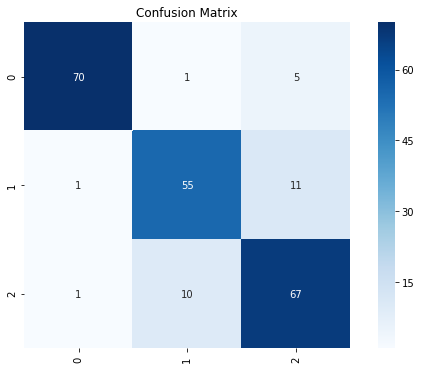

In [17]:
plot_confusion_matrix(bag_labels=BAG_TEST,bag_predictions=bagPredictions,class_labels = {0,1,2})

# TEST RUN

In [ ]:
tf.reset_default_graph()
emiDriver.initializeSession(g1)
emiDriver.loadSavedGraphToNewSession(MODEL_PREFIX, 1006)
k = 2

In [18]:
%%time
predictions, predictionStep = emiDriver.getInstancePredictions(x_test, y_test, earlyPolicy_minProb,
                                                            minProb=0.99, keep_prob=1.0)
bagPredictions = emiDriver.getBagPredictions(predictions, minSubsequenceLen=k, numClass=NUM_OUTPUT)
print('Accuracy at k = %d: %f' % (k,  np.mean((bagPredictions == BAG_TEST).astype(int))))

Accuracy at k = 2: 0.868778
CPU times: user 354 ms, sys: 184 ms, total: 538 ms
Wall time: 98.3 ms


In [17]:
# A slightly more detailed analysis method is provided. 
df = emiDriver.analyseModel(predictions, BAG_TEST, NUM_SUBINSTANCE, NUM_OUTPUT)

   len       acc  macro-fsc  macro-pre  macro-rec  micro-fsc  micro-pre  \
0    1  0.823529   0.825387   0.841677   0.823591   0.823529   0.823529   
1    2  0.868778   0.868437   0.870928   0.866974   0.868778   0.868778   
2    3  0.837104   0.834236   0.842061   0.833776   0.837104   0.837104   
3    4  0.751131   0.749435   0.802254   0.747079   0.751131   0.751131   
4    5  0.687783   0.685419   0.798230   0.683153   0.687783   0.687783   
5    6  0.610860   0.601129   0.783751   0.606995   0.610860   0.610860   

   micro-rec  
0   0.823529  
1   0.868778  
2   0.837104  
3   0.751131  
4   0.687783  
5   0.610860  
Max accuracy 0.868778 at subsequencelength 2
Max micro-f 0.868778 at subsequencelength 2
Micro-precision 0.868778 at subsequencelength 2
Micro-recall 0.868778 at subsequencelength 2
Max macro-f 0.868437 at subsequencelength 2
macro-precision 0.870928 at subsequencelength 2
macro-recall 0.866974 at subsequencelength 2
